# Exploration

In [2]:
import time
import os
# os.environ["MKL_THREADING_LAYER"] = "GNU"
import keras
# import theano
import tensorflow
import numpy as np
import pandas as pd
import decimal
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor


from imgaug import augmenters as iaa

# Set the randomizer seed so results are the same each time.
np.random.seed(0)
pd.options.display.max_columns = 30
print('keras version:', keras.__version__)
try:
    print('tensorflow version:', tensorflow.__version__)
except:
    print('theano version:', theano.__version__)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)

C:\Users\alexd\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
pandas version: 0.23.0
numpy version: 1.14.3


### Examine the data

In [3]:
train = pd.read_csv('training.csv')
train['Image'] = train.Image.apply(lambda im: np.fromstring(im, sep=' '))
full_data = train.Image
full_labels = train[train.columns[:-1]]
features = full_labels.columns

In [4]:
del train, full_data, full_labels

In [4]:
print(train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [5]:
full_labels.sample(10)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
4411,71.079000,39.584208,26.331576,38.054388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.366640,69.798240,NaN,NaN,NaN,NaN,NaN,NaN,46.984200,81.271920
4901,64.399591,38.503814,29.440197,39.945433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.739687,63.732223,NaN,NaN,NaN,NaN,NaN,NaN,48.181306,75.265206
6794,69.260800,40.359393,28.490869,36.186097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.826152,75.671945,NaN,NaN,NaN,NaN,NaN,NaN,45.184110,84.981572
2724,73.352348,38.401461,32.468452,38.401461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.224209,76.604661,NaN,NaN,NaN,NaN,NaN,NaN,49.894330,88.668730
6648,65.515296,36.871904,29.650475,40.187136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.350197,66.106251,NaN,NaN,NaN,NaN,NaN,NaN,52.254357,77.558827
5633,63.327308,38.484376,35.244195,39.906318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.463611,59.102426,NaN,NaN,NaN,NaN,NaN,NaN,48.752692,70.833366
526,66.328960,36.912768,32.007040,35.196608,59.751040,38.342848,71.477760,37.198784,36.869120,36.912768,25.428480,34.910592,55.460480,30.048256,77.484160,28.046144,38.013440,29.476224,19.422080,26.902016,45.163520,62.940800,58.606720,76.955520,31.434880,75.811840,45.163520,74.095360,44.019840,84.392320
296,64.918419,38.881725,28.223425,36.297772,58.457677,39.399090,71.378587,39.915880,33.908695,37.331353,22.280048,36.556455,57.424096,30.354395,79.647808,33.713763,36.751329,27.253423,15.819880,25.702937,45.278659,59.813174,56.907305,83.587257,32.616431,82.295569,45.278659,77.385772,45.278659,92.373269
5649,64.263628,35.499572,31.193526,38.590214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.955944,65.788019,NaN,NaN,NaN,NaN,NaN,NaN,50.355572,82.786605
2162,67.690269,35.696894,29.502277,37.127950,60.322981,36.359420,75.983503,37.477234,39.095652,37.684472,21.211694,39.522054,58.173582,29.979931,79.683431,30.736394,40.084259,31.229739,19.396652,30.506166,49.396330,60.597097,68.056859,71.180585,33.458101,74.460088,50.136717,76.991396,49.879042,77.060266


### Look at some examples of missing labels

In [6]:
def plot_sample(data, labels):
    '''
    data must be a numpy.ndarray of shape (16, 9216)
    labels must be a numpy.ndarray (16, 30)
    the indices must line up between the two
    '''
    
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, 
                        bottom=0, top=1, 
                        hspace=0.05, wspace=0.05)
    for i in range(labels.shape[0]):
        img = data[i].reshape(96,96)
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(96,96), cmap='gray')
        ax.scatter(labels[i][0::2] * 48 + 48, 
                   labels[i][1::2] * 48 + 48, c='r')

In [7]:
missing_labels = full_labels[pd.isna(full_labels.left_eye_inner_corner_x)]
idx = missing_labels.sample(16).index.values

In [8]:
missing_labels_sample = missing_labels.loc[idx]
missing_labels_sample

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
4766,65.849805,36.064320,30.786035,37.224230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.411379,63.902093,NaN,NaN,NaN,NaN,NaN,NaN,48.184653,73.954624
3198,68.605471,37.497074,30.937084,37.287809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.608258,63.655665,NaN,NaN,NaN,NaN,NaN,NaN,49.980542,78.932284
3665,67.603547,39.496598,30.348607,35.238940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.186140,68.590959,NaN,NaN,NaN,NaN,NaN,NaN,43.121696,77.815865
2341,66.190080,40.266831,29.448738,39.149612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.231705,69.585674,NaN,NaN,NaN,NaN,NaN,NaN,49.489477,78.863778
2983,65.931345,36.832785,27.610327,36.832785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.931782,67.374255,NaN,NaN,NaN,NaN,NaN,NaN,48.643636,82.068800
3779,68.275238,39.425990,34.841587,35.492621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.852870,62.370643,NaN,NaN,NaN,NaN,NaN,NaN,52.213978,73.515206
4997,64.061982,39.366823,28.532086,38.911311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.752443,63.964490,NaN,NaN,NaN,NaN,NaN,NaN,46.296960,71.252677
3243,69.288000,46.060465,29.645247,35.158705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.812577,76.783702,NaN,NaN,NaN,NaN,NaN,NaN,31.627312,88.428726
4640,62.035446,37.299963,35.725538,38.944320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.880492,57.032320,NaN,NaN,NaN,NaN,NaN,NaN,49.702646,66.076308
6141,63.051757,44.531530,33.423861,39.954877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.358226,70.064452,NaN,NaN,NaN,NaN,NaN,NaN,43.540696,83.553600


In [9]:
missing_data = full_data.loc[missing_labels.index.values]
missing_data_sample = missing_data.loc[idx].values

In [10]:
missing_labels_sample = (missing_labels_sample.values - 48) / 48

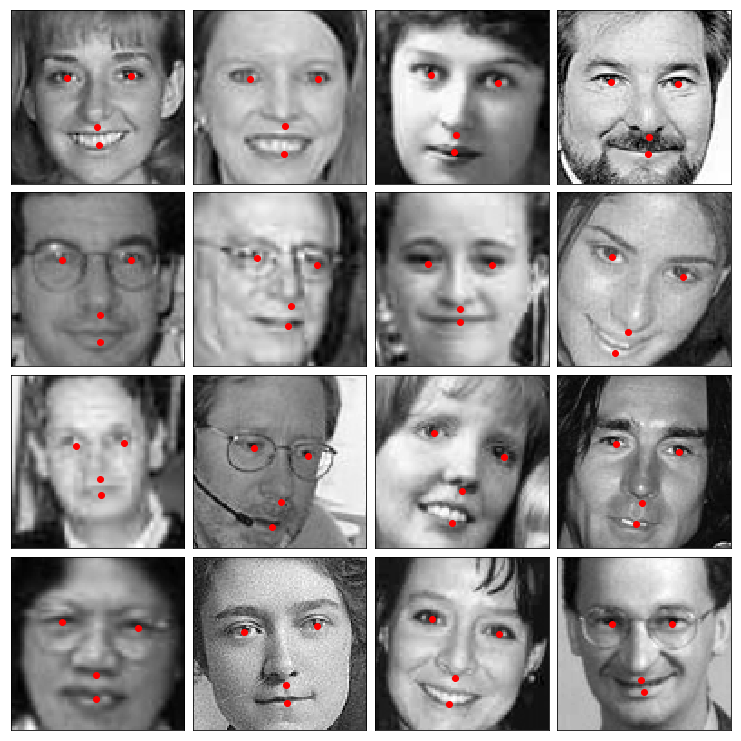

In [11]:
plot_sample(missing_data_sample, missing_labels_sample)

### Load the data for real

In [5]:
def load_data(test=False):
    
    # load the raw data
    if test: df = pd.read_csv('test.csv')
    else: df = pd.read_csv('training.csv')
    
    # convert the image format
    df['Image'] = df.Image.apply(lambda im: np.fromstring(im, sep=' '))
    
    # drop missing values
    df = df.dropna()
    
    # separate data and reshape the images
    data = df.Image.values
    data = np.stack(data) / 255
    data = data.reshape(-1, 96, 96, 1)
    
    # separate the labels and scale them to [-1,1] interval
    if test:
        labels = None
        print(data.shape)
    else:
        labels = df[df.columns[:-1]].values
        labels = (labels - 48) / 48
        data, labels = shuffle(data, labels, random_state=666)
        print(data.shape, labels.shape)
    
    return data, labels

In [6]:
train_data, train_labels = load_data()

(2140, 96, 96, 1) (2140, 30)


### Print some examples

In [14]:
idx = np.random.randint(0, len(train_data), 16)

In [15]:
data_sample = train_data[idx, :, :, :]
label_sample = train_labels[idx, :]

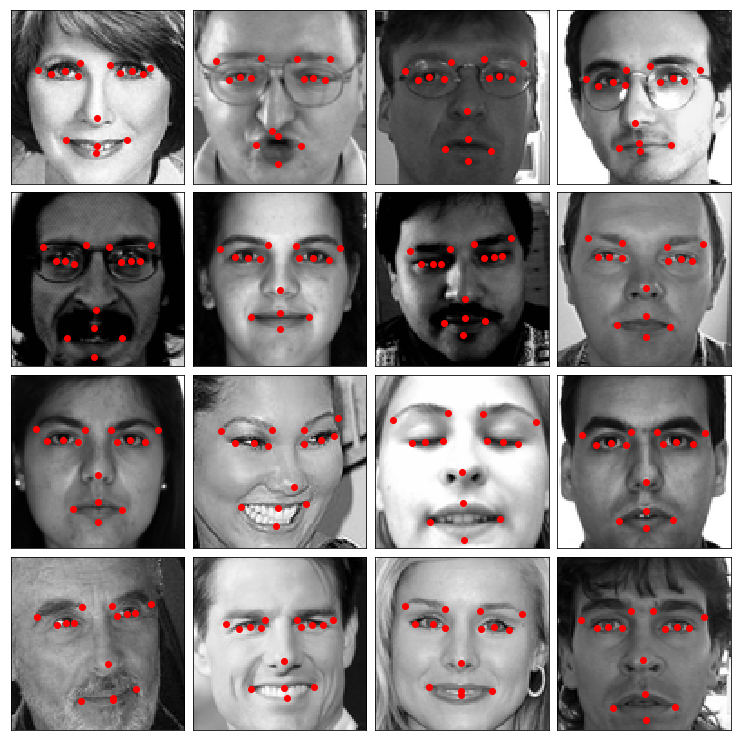

In [16]:
plot_sample(data_sample, label_sample)

## Testing imgaug

In [17]:
train_data.shape

(2140, 96, 96, 1)

## Mirror images to create larger training set

In [7]:
def flip_data(data, labels, features):
    # flip the images
    data_flipped = data[:, :, ::-1, :]
    
    # flip the labels
    labels_flipped = np.zeros(labels.shape)
    for idx in range(len(labels)):
        for i,s1 in enumerate(features):
            parts = s1.partition('_')
            if parts[0] == 'left' or parts[0] == 'right':
                coord = parts[-1]
            elif parts[0] == 'mouth':
                parts = s1.split('_', maxsplit=2)
                if 'corner' in parts[-1]:
                    coord = parts[-1]        
                elif 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            else:
                if 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            for j in range(i+1,len(features)-1):
                s2 = features[j]
                if coord in s2:
                    if 'x' in coord:
                        labels_flipped[idx,i] = labels[idx,j] * -1
                        labels_flipped[idx,j] = labels[idx,i] * -1
                    else:
                        labels_flipped[idx,i] = labels[idx,j]
                        labels_flipped[idx,j] = labels[idx,i]
                
    return data_flipped, labels_flipped

In [8]:
train_data_flipped, train_labels_flipped = flip_data(train_data, train_labels, list(features))

In [7]:
idx = np.random.randint(0, len(train_data), 16)

In [27]:
data_sample = train_data[idx, :, :, :]
label_sample = train_labels[idx, :]

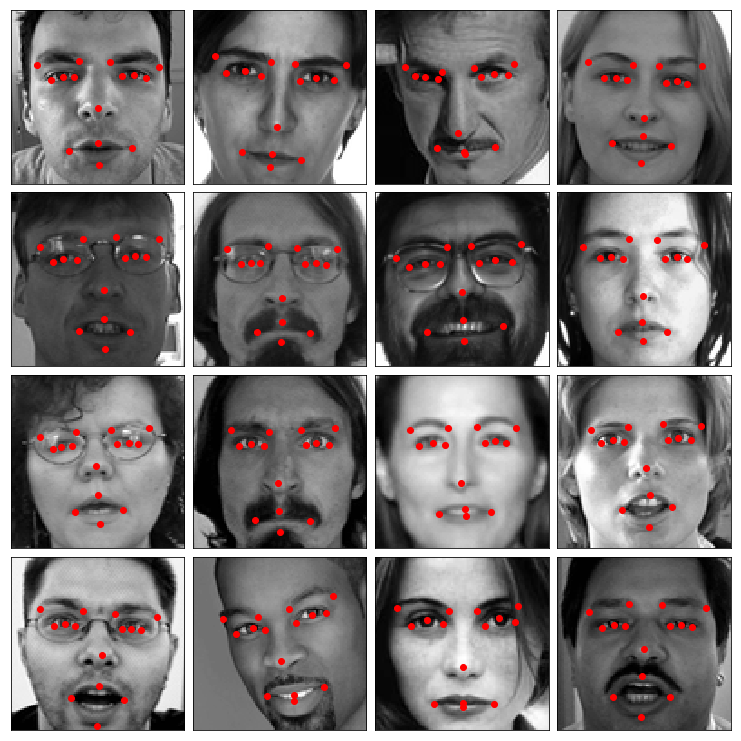

In [28]:
plot_sample(data_sample, label_sample)

In [29]:
data_sample_flipped = train_data_flipped[idx, :, :, :]
label_sample_flipped = train_labels_flipped[idx, :]

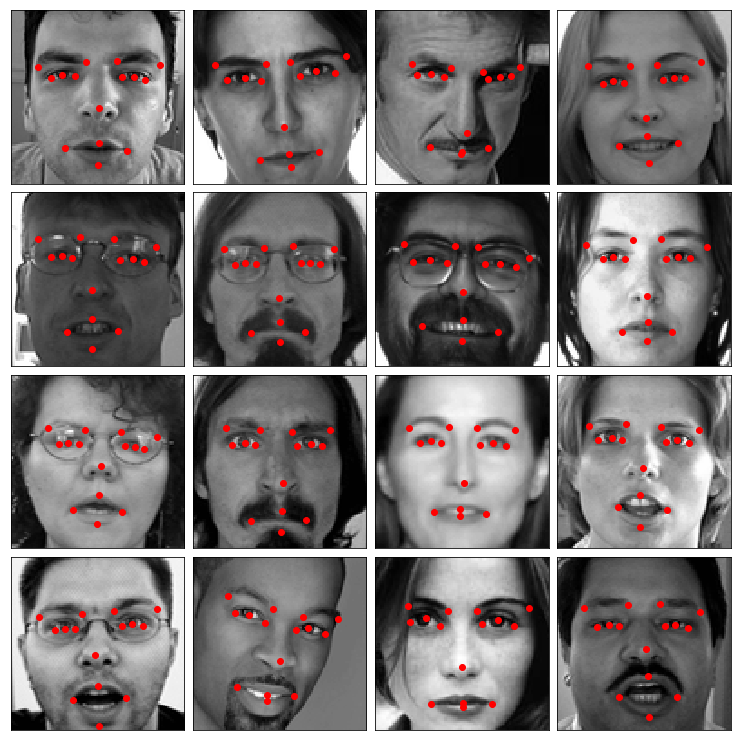

In [30]:
plot_sample(data_sample_flipped, label_sample_flipped)

## Combine mirrored and original data

In [9]:
train_data_set = np.concatenate((train_data, train_data_flipped), axis=0)
train_data.shape, train_data_flipped.shape, train_data_set.shape

((2140, 96, 96, 1), (2140, 96, 96, 1), (4280, 96, 96, 1))

In [10]:
train_labels_set = np.concatenate((train_labels, train_labels_flipped), axis=0)
train_labels.shape, train_labels_flipped.shape, train_labels_set.shape

((2140, 30), (2140, 30), (4280, 30))

# Recreate Daniel Nouri model in Keras

## Creating a time callback

In [27]:
# making a callback so I can compare runtimes
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

## model generator function

In [11]:
def build_CNN(
    num_ConvLayers=3, 
    num_DenseLayers=2,
    filters=[32,64,128],
    kernels=[(3,3), (3,3), (3,3)], 
    pools=[(2,2),(2,2),(2,2)], 
    dense_nodes=[1000,1000], 
    optimizer=keras.optimizers.Adam(), 
    dropout=None,
    input_shape=(96,96,1)
):
    '''This function builds a CNN model
    num_ConvLayers --> is the number of convolutional layer groups where 
    each group contains a convolutional layer, a pooling layer, and an
    optional dropout layer
    
    num_DenseLayers --> is the number of dense layers after flattening
    the convolutional output
    
    filters --> a list of the number of filters used in each
    convolutional layer specified in num_ConvLayers
    
    kernels --> a list of the kernel size to use in each convolutional
    layer specified in num_ConvLayers
    
    pools --> a list of the kernel size to use in each pooling layer
    specified in num_ConvLayers
    
    dense_nodes --> a list of the number of units in each dense layer
    specified in num_DenseLayers
    
    dropout --> optional, a list of the dropout rates at each 
    convolutional layer
    
    input_shape --> the shape of the input data
    '''
    
    # define a Sequential model
    model = Sequential()
    
    # add convolutional layer groups
    for i in range(num_ConvLayers):
        model.add(Conv2D(
            filters=filters[i],
            kernel_size=kernels[i],
            strides=(1,1),
            padding='same',
            activation='relu',
            input_shape=input_shape
        ))
        model.add(MaxPooling2D(
            pool_size=pools[i],
            strides=None
        ))
        
        # add dropout layers if specified
        if dropout:
            model.add(Dropout(rate=dropout[i]))
    
    # flatten the convolutional layers
    model.add(Flatten())
    
    # add the dense layers
    for j in range(num_DenseLayers):
        model.add(Dense(
            units=dense_nodes[j],
            activation='relu'
        ))
        
    # create the output layer
    model.add(Dense(units=30))
    
    # compile the model
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

## train model on original test data with missing points dropped

In [65]:
model1 = build_CNN()

In [64]:
time_callback = TimeHistory()
hist1 = model1.fit(
    train_data, train_labels, 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist2.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 3424 samples, validate on 856 samples
Epoch 1/4
 160/3424 [>.............................] - ETA: 1:51 - loss: 0.2099

KeyboardInterrupt: 

In [ ]:
val_rms = np.sqrt(hist1.history['val_loss']) * 48
train_rms = np.sqrt(hist1.history['loss']) * 48

plt.plot(val_rms, 'g-')
plt.plot(train_rms, 'b-')
plt.legend(['validation loss','training loss'])

### Using original and mirrored data

In [66]:
model2 = build_CNN()

In [35]:
time_callback = TimeHistory()
hist2 = model2.fit(
    train_data_set, train_labels_set, 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist2.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 3424 samples, validate on 856 samples
Epoch 1/10
3424/3424 [==============================] - 150s 44ms/step - loss: 0.0129 - val_loss: 0.0035
Epoch 2/10
3424/3424 [==============================] - 133s 39ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 3/10
3424/3424 [==============================] - 89s 26ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/10
3424/3424 [==============================] - 89s 26ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/10
3424/3424 [==============================] - 88s 26ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/10
3424/3424 [==============================] - 86s 25ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/10
3424/3424 [==============================] - 87s 25ms/step - loss: 8.9291e-04 - val_loss: 0.0011
Epoch 8/10
3424/3424 [==============================] - 88s 26ms/step - loss: 7.8390e-04 - val_loss: 0.0011
Epoch 9/10
3424/3424 [==============================] - 88s 26ms/step - loss: 7.0623e-04 - val_loss: 0.0010
Epo

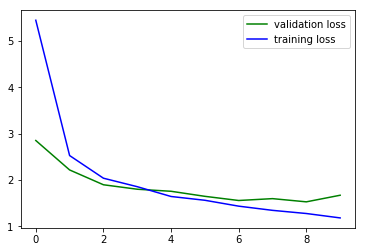

In [36]:
val_rms = np.sqrt(hist2.history['val_loss']) * 48
train_rms = np.sqrt(hist2.history['loss']) * 48

plt.plot(val_rms, 'g-')
plt.plot(train_rms, 'b-')
plt.legend(['validation loss','training loss'])

In [47]:
plot_model(model2, to_file='model.png', show_shapes=True)

(-0.5, 530.5, 1400.5, -0.5)

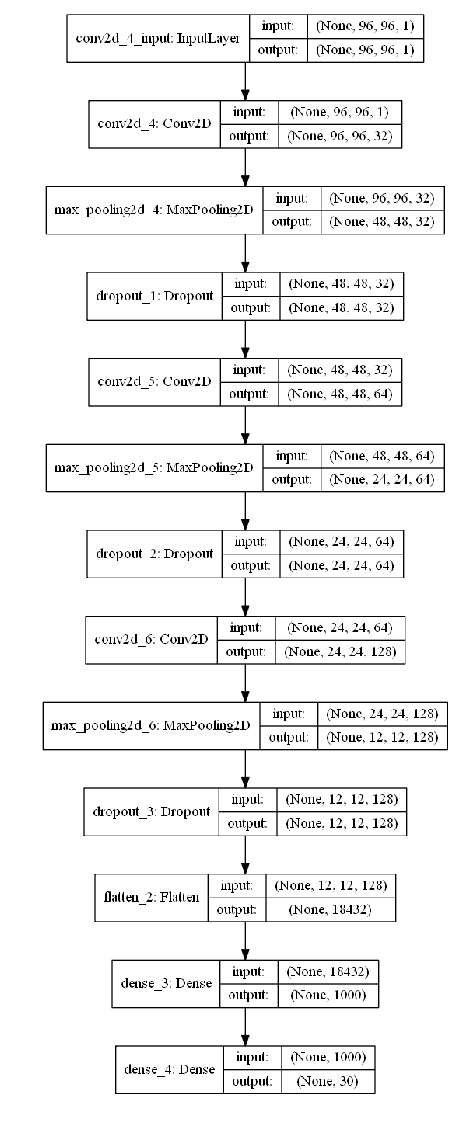

In [48]:
mod = plt.imread('model.png')
fig = plt.figure(figsize=(10,20), frameon=False)
plt.imshow(mod)
plt.axis('off')

## Adding Dropout layers

In [67]:
model3 = build_CNN(dropout=[.1, .2, .3])

In [44]:
time_callback = TimeHistory()
hist3 = model3.fit(
    train_data_set, train_labels_set, 
    batch_size=32,
    epochs=10, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[keras.callbacks.History(), time_callback]
)
print('\nRMS error on validation set:', np.sqrt(hist3.history['val_loss'][-1]) * 48)
print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

Train on 3424 samples, validate on 856 samples
Epoch 1/10
3424/3424 [==============================] - 96s 28ms/step - loss: 0.0432 - val_loss: 0.0161
Epoch 2/10
3424/3424 [==============================] - 97s 28ms/step - loss: 0.0044 - val_loss: 0.0138
Epoch 3/10
3424/3424 [==============================] - 96s 28ms/step - loss: 0.0034 - val_loss: 0.0154
Epoch 4/10
3424/3424 [==============================] - 100s 29ms/step - loss: 0.0027 - val_loss: 0.0094
Epoch 5/10
3424/3424 [==============================] - 95s 28ms/step - loss: 0.0025 - val_loss: 0.0097
Epoch 6/10
3424/3424 [==============================] - 99s 29ms/step - loss: 0.0023 - val_loss: 0.0128
Epoch 7/10
3424/3424 [==============================] - 100s 29ms/step - loss: 0.0022 - val_loss: 0.0076
Epoch 8/10
3424/3424 [==============================] - 96s 28ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 9/10
3424/3424 [==============================] - 101s 29ms/step - loss: 0.0019 - val_loss: 0.0062
Epoch 10/10
34

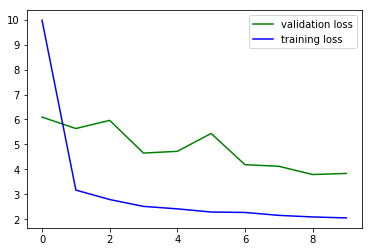

In [45]:
val_rms = np.sqrt(hist3.history['val_loss']) * 48
train_rms = np.sqrt(hist3.history['loss']) * 48

plt.plot(val_rms, 'g-')
plt.plot(train_rms, 'b-')
plt.legend(['validation loss','training loss'])

## Trying out visualizers

In [47]:
plot_model(model3, to_file='model.png', show_shapes=True)

(-0.5, 530.5, 1400.5, -0.5)

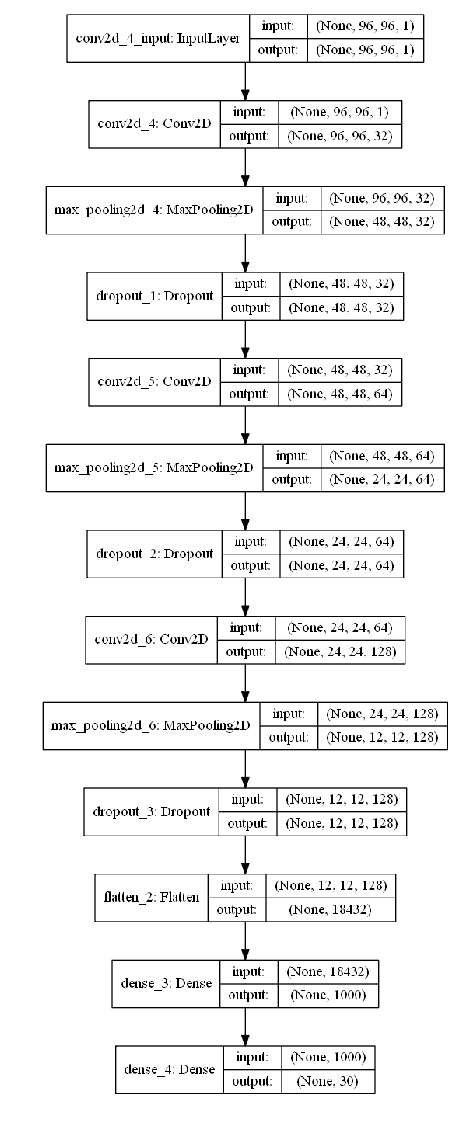

In [48]:
mod = plt.imread('model.png')
fig = plt.figure(figsize=(10,20), frameon=False)
plt.imshow(mod)
plt.axis('off')

## Trying to wrap model into grid_search

In [12]:
# model = KerasClassifier(build_fn=build_CNN, epochs=10)
model = KerasRegressor(build_fn=build_CNN, epochs=10, )

In [13]:
f = list(range(8,72,8))
filts = [[i, i*2, i*4] for i in f]
# filts = [[i] for i in f]
filts, len(filts)

([[8, 16, 32],
  [16, 32, 64],
  [24, 48, 96],
  [32, 64, 128],
  [40, 80, 160],
  [48, 96, 192],
  [56, 112, 224],
  [64, 128, 256]],
 8)

In [14]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

In [15]:
k1 = [[(i,i)]*3 for i in range(2,5)]
k2 = [
    [(4,4), (3,3), (2,2)], 
    [(3,3), (2,2), (2,2)], 
    [(2,2), (3,3), (4,4)],
    [(2,2), (2,2), (3,3)],
    [(3,3), (3,3), (2,2)],
    [(2,2), (3,3), (3,3)],
]
k = k1 + k2
k, len(k)

([[(2, 2), (2, 2), (2, 2)],
  [(3, 3), (3, 3), (3, 3)],
  [(4, 4), (4, 4), (4, 4)],
  [(4, 4), (3, 3), (2, 2)],
  [(3, 3), (2, 2), (2, 2)],
  [(2, 2), (3, 3), (4, 4)],
  [(2, 2), (2, 2), (3, 3)],
  [(3, 3), (3, 3), (2, 2)],
  [(2, 2), (3, 3), (3, 3)]],
 9)

In [16]:
# param_grid = dict(optimizer=optimizer, filters=filts, kernels=k)
# param_grid = dict(optimizer=optimizer, kernels=k)
param_grid = dict(filters=filts, kernels=k)
param_grid

{'filters': [[8, 16, 32],
  [16, 32, 64],
  [24, 48, 96],
  [32, 64, 128],
  [40, 80, 160],
  [48, 96, 192],
  [56, 112, 224],
  [64, 128, 256]],
 'kernels': [[(2, 2), (2, 2), (2, 2)],
  [(3, 3), (3, 3), (3, 3)],
  [(4, 4), (4, 4), (4, 4)],
  [(4, 4), (3, 3), (2, 2)],
  [(3, 3), (2, 2), (2, 2)],
  [(2, 2), (3, 3), (4, 4)],
  [(2, 2), (2, 2), (3, 3)],
  [(3, 3), (3, 3), (2, 2)],
  [(2, 2), (3, 3), (3, 3)]]}

In [17]:
grid = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
#     n_jobs=-1,
    scoring='neg_mean_squared_error',
)

In [18]:
grid_data, grid_labels = shuffle(train_data_set, train_labels_set, random_state=666)
grid_data, grid_labels = grid_data[:100], grid_labels[:100]
grid_data.shape, grid_labels.shape

((100, 96, 96, 1), (100, 30))

In [20]:
del train_data, train_data_flipped, train_data_set, train_labels, train_labels_flipped, train_labels_set

In [21]:
whos

Variable             Type              Data/Info
------------------------------------------------
Conv2D               type              <class 'keras.layers.convolutional.Conv2D'>
Dense                type              <class 'keras.layers.core.Dense'>
Dropout              type              <class 'keras.layers.core.Dropout'>
Flatten              type              <class 'keras.layers.core.Flatten'>
GridSearchCV         ABCMeta           <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
KerasClassifier      type              <class 'keras.wrappers.sc<...>t_learn.KerasClassifier'>
KerasRegressor       type              <class 'keras.wrappers.sc<...>it_learn.KerasRegressor'>
MaxPooling2D         type              <class 'keras.layers.pooling.MaxPooling2D'>
MultipleLocator      type              <class 'matplotlib.ticker.MultipleLocator'>
Sequential           type              <class 'keras.engine.sequential.Sequential'>
build_CNN            function          <function build_CNN at

In [19]:
grid_result = grid.fit(grid_data, grid_labels, verbose=1)

C:\Users\alexd\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/10
66/66 [==============================] - 2s 37ms/step - loss: 0.0959
Epoch 2/10
66/66 [==============================] - 1s 10ms/step - loss: 0.0314
Epoch 3/10
66/66 [==============================] - 1s 10ms/step - loss: 0.0328
Epoch 4/10
66/66 [==============================] - 1s 10ms/step - loss: 0.0127
Epoch 5/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0116
Epoch 6/10
66/66 [==============================] - 1s 10ms/step - loss: 0.0116
Epoch 7/10
66/66 [==============================] - 1s 10ms/step - loss: 0.0092
Epoch 8/10
66/66 [==============================] - 1s 10ms/step - loss: 0.0123
Epoch 9/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0096
Epoch 10/10
66/66 [==============================] - 1s 11ms/step - loss: 0.0094
Epoch 1/10
67/67 [==============================] - 2s 34ms/step - loss: 0.0992
Epoch 2/10
67/67 [==============================] - 1s 10ms/step - loss: 0.0450
Epoch 3/10
67/67 [=====================

67/67 [==============================] - 1s 12ms/step - loss: 0.0150
Epoch 6/10
67/67 [==============================] - 1s 13ms/step - loss: 0.0126
Epoch 7/10
67/67 [==============================] - 1s 11ms/step - loss: 0.0123
Epoch 8/10
67/67 [==============================] - 1s 11ms/step - loss: 0.0128
Epoch 9/10
67/67 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 10/10
67/67 [==============================] - 1s 11ms/step - loss: 0.0066
Epoch 1/10
66/66 [==============================] - 4s 61ms/step - loss: 1.1383
Epoch 2/10
66/66 [==============================] - 1s 13ms/step - loss: 0.0823
Epoch 3/10
66/66 [==============================] - 1s 13ms/step - loss: 0.0429
Epoch 4/10
66/66 [==============================] - 1s 13ms/step - loss: 0.0200
Epoch 5/10
66/66 [==============================] - 1s 13ms/step - loss: 0.0273
Epoch 6/10
66/66 [==============================] - 1s 13ms/step - loss: 0.0173
Epoch 7/10
66/66 [==============================] 

67/67 [==============================] - 1s 14ms/step - loss: 0.0156
Epoch 10/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0107
Epoch 1/10
67/67 [==============================] - 4s 58ms/step - loss: 15.6871
Epoch 2/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0460
Epoch 3/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0188
Epoch 4/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0641
Epoch 5/10
67/67 [==============================] - 1s 13ms/step - loss: 0.0550
Epoch 6/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0139
Epoch 7/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0131
Epoch 8/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0152
Epoch 9/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0068
Epoch 10/10
67/67 [==============================] - 1s 14ms/step - loss: 0.0095
Epoch 1/10
66/66 [==============================

67/67 [==============================] - 2s 29ms/step - loss: 0.1292
Epoch 4/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0975
Epoch 5/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0748
Epoch 6/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0300
Epoch 7/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0085
Epoch 8/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0099
Epoch 9/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0083
Epoch 10/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0077
Epoch 1/10
67/67 [==============================] - 6s 93ms/step - loss: 31.3512
Epoch 2/10
67/67 [==============================] - 2s 29ms/step - loss: 0.1150
Epoch 3/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0653
Epoch 4/10
67/67 [==============================] - 2s 34ms/step - loss: 0.0399
Epoch 5/10
67/67 [==============================]

66/66 [==============================] - 2s 27ms/step - loss: 0.0143
Epoch 8/10
66/66 [==============================] - 2s 27ms/step - loss: 0.0105
Epoch 9/10
66/66 [==============================] - 2s 27ms/step - loss: 0.0103
Epoch 10/10
66/66 [==============================] - 2s 27ms/step - loss: 0.0088
Epoch 1/10
67/67 [==============================] - 8s 114ms/step - loss: 11.3011
Epoch 2/10
67/67 [==============================] - 2s 27ms/step - loss: 0.1055
Epoch 3/10
67/67 [==============================] - 2s 27ms/step - loss: 0.0241
Epoch 4/10
67/67 [==============================] - 2s 27ms/step - loss: 0.0148
Epoch 5/10
67/67 [==============================] - 2s 27ms/step - loss: 0.0277
Epoch 6/10
67/67 [==============================] - 2s 27ms/step - loss: 0.0121
Epoch 7/10
67/67 [==============================] - 2s 27ms/step - loss: 0.0103
Epoch 8/10
67/67 [==============================] - 2s 28ms/step - loss: 0.0076
Epoch 9/10
67/67 [==============================

66/66 [==============================] - 10s 146ms/step - loss: 14.6298
Epoch 2/10
66/66 [==============================] - 2s 31ms/step - loss: 0.0964
Epoch 3/10
66/66 [==============================] - 2s 30ms/step - loss: 0.0472
Epoch 4/10
66/66 [==============================] - 2s 30ms/step - loss: 0.0180
Epoch 5/10
66/66 [==============================] - 2s 30ms/step - loss: 0.0205
Epoch 6/10
66/66 [==============================] - 2s 31ms/step - loss: 0.0093
Epoch 7/10
66/66 [==============================] - 2s 31ms/step - loss: 0.0122
Epoch 8/10
66/66 [==============================] - 2s 30ms/step - loss: 0.0089
Epoch 9/10
66/66 [==============================] - 2s 31ms/step - loss: 0.0069
Epoch 10/10
66/66 [==============================] - 2s 30ms/step - loss: 0.0058
Epoch 1/10
67/67 [==============================] - 10s 149ms/step - loss: 6.6713
Epoch 2/10
67/67 [==============================] - 2s 31ms/step - loss: 0.1373
Epoch 3/10
67/67 [===========================

67/67 [==============================] - 3s 42ms/step - loss: 0.0400
Epoch 4/10
67/67 [==============================] - 3s 42ms/step - loss: 0.0261
Epoch 5/10
67/67 [==============================] - 3s 43ms/step - loss: 0.0213
Epoch 6/10
67/67 [==============================] - 3s 42ms/step - loss: 0.0120
Epoch 7/10
67/67 [==============================] - 3s 43ms/step - loss: 0.0101
Epoch 8/10
67/67 [==============================] - 3s 42ms/step - loss: 0.0080
Epoch 9/10
67/67 [==============================] - 3s 42ms/step - loss: 0.0079
Epoch 10/10
67/67 [==============================] - 3s 42ms/step - loss: 0.0055
Epoch 1/10
67/67 [==============================] - 12s 174ms/step - loss: 249.9712
Epoch 2/10
67/67 [==============================] - 3s 42ms/step - loss: 0.1390
Epoch 3/10
67/67 [==============================] - 3s 42ms/step - loss: 0.3811
Epoch 4/10
67/67 [==============================] - 3s 42ms/step - loss: 0.1406
Epoch 5/10
67/67 [============================

C:\Users\alexd\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:542: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ResourceExhaustedError: OOM when allocating tensor with shape[23040,1000] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node training_116/Adam/mul_32}} = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](training_116/Adam/sub_14, training_116/Adam/gradients/dense_349/MatMul_grad/MatMul_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
cv_results = pd.DataFrame(grid_result.cv_results_)
cv_results.head()

In [ ]:
# cv_results.to_csv('grid_search_results1.csv')
cv_results.to_csv('grid_search_results2.csv')

In [ ]:
grid_result.best_params_

## Predicting on the test data

In [37]:
test_data, test_labels = load_data(test=True)
# test_data.shape

(1783, 96, 96, 1)


In [38]:
pred1 = model1.predict(test_data)
pred2 = model2.predict(test_data)
pred3 = model3.predict(test_data)

array([ 0.33338356, -0.20914243, -0.3742541 , -0.23212862,  0.22483534,
       -0.19258703,  0.4787927 , -0.17071468, -0.23158202, -0.18802537,
       -0.49957383, -0.21526776,  0.19954605, -0.44583464,  0.6284229 ,
       -0.38660938, -0.17172971, -0.4549977 , -0.65153575, -0.4330452 ,
        0.05763973,  0.04605208,  0.31278968,  0.5520119 , -0.2943003 ,
        0.5572274 ,  0.03446224,  0.3852408 ,  0.01163444,  0.75977194],
      dtype=float32)

In [39]:
idx = np.random.randint(0, len(test_data), 16)

In [40]:
test_sample = test_data[idx, :, :, :]
pred_sample = pred[idx, :]

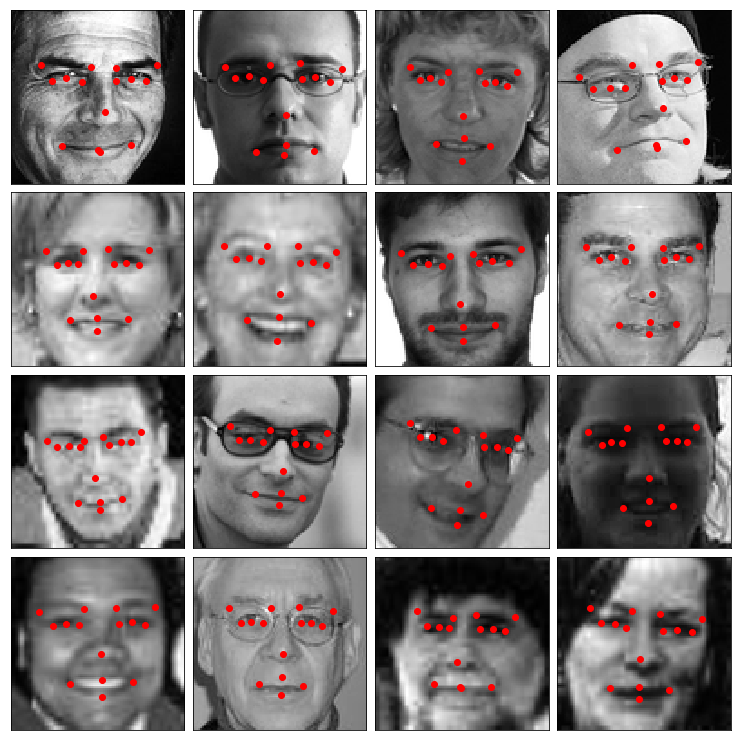

In [41]:
plot_sample(test_sample, pred_sample)

## BACKUP

## Original Model

In [ ]:
# model = Sequential()

# # first group of layers
# model.add(Conv2D(
#     32, 
#     kernel_size=(3,3), 
#     activation='relu',
#     input_shape=(96, 96, 1), 
# #     data_format='channels_first'
# ))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # second group of layers
# model.add(Conv2D(
#     64, 
#     kernel_size=(2, 2), 
#     activation='relu'
# ))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # third group of layers
# model.add(Conv2D(
#     128, 
#     kernel_size=(2, 2), 
#     activation='relu'
# ))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(500, activation='relu'))
# model.add(Dense(30))

# # sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# adagrad = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
# model.compile(loss='mean_squared_error', optimizer=adagrad)

In [ ]:
# time_callback = TimeHistory()
# hist = model.fit(
#     train_data, train_labels, 
#     batch_size=32,
#     epochs=4,
#     validation_split=0.2, 
#     verbose=1,
#     callbacks=[keras.callbacks.History(), time_callback]
# )
# print('RMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
# print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))

In [43]:
model = Sequential()

# FIRST CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=32, # don't yet fully understand how to choose this dimension
    kernel_size=(3,3),
    strides=(1,1),
    padding='same',
    activation='relu',
    input_shape=(96, 96, 1),
))
# input_shape = (batch, rows, cols, channels) --> (batch, 96, 96, 1)
# padding = 'same' so for a kernel of size (3,3) and strides=(1,1) this 
# will pad two rows and two columns of zeros on the edges so that the 
# output shape gives an tensor with 96 rows and 96 columns
# output_shape = (batch, new_rows, new_cols, filters) --> (batch, 96, 96, 32)

# POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=None
))
# setting strides=None sets the strides to a default of pool_size, so 
# here we are really setting strides=(2,2) which is what we want so we 
# don't miss any pixels and we don't count any pixels more than once
# the strides is essentially the factor by which to downscale the output
# so setting the strides=(2,2) will have the dimensions of input
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 48, 48, 32)

# FIRST DROPOUT LAYER
# drop 10% of data
model.add(Dropout(rate=0.1))

# SECOND CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=64, # don't know why we increased this number by 2
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 48, 48, 32)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 48, 48, 64)

# SECOND POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2), 
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 48, 48, 64)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 24, 24, 64)

# SECOND DROPOUT LAYER
# drop 20% of data
model.add(Dropout(rate=0.2))


# THIRD CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=128, # don't know how to choose this value
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 24, 24, 64)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 24, 24, 128)

# THIRD POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 24, 24, 128)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 12, 12, 128)

# SECOND DROPOUT LAYER
# drop 30% of data
model.add(Dropout(rate=0.3))

# FLATTEN THE POOLED OUTPUT TO CLASSIFY
model.add(Flatten())
# flatten the output into a single layer of 
#     shape = [batch, pool_rows * pool_cols * in_filters]
#         --> [batch, 12 * 12 * 128] = [batch, 18432]

# ADD ONE FULLY CONNECTED LAYER TO PROCESS THE FLATTENED DATA
model.add(Dense(
#     500,
    1000,
    activation='relu'
))
# input_shape = [batch, flattened_nodes] = [batch, 18432]
# output_shape = [batch, out_nodes] = [batch, 500]

# FINAL OUTPUT LAYER
model.add(Dense(30))
# input_shape = [batch, in_nodes] = [batch, 500]
# output_shape = [batch, num_classes] = [batch, 30]

# opt = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# opt = keras.optimizers.Adagrad()
# opt = keras.optimizers.Nadam()
opt = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=opt)

In [34]:
model = Sequential()

# FIRST CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=32, # don't yet fully understand how to choose this dimension
    kernel_size=(3,3),
    strides=(1,1),
    padding='same',
    activation='relu',
    input_shape=(96, 96, 1),
))
# input_shape = (batch, rows, cols, channels) --> (batch, 96, 96, 1)
# padding = 'same' so for a kernel of size (3,3) and strides=(1,1) this 
# will pad two rows and two columns of zeros on the edges so that the 
# output shape gives an tensor with 96 rows and 96 columns
# output_shape = (batch, new_rows, new_cols, filters) --> (batch, 96, 96, 32)

# POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=None
))
# setting strides=None sets the strides to a default of pool_size, so 
# here we are really setting strides=(2,2) which is what we want so we 
# don't miss any pixels and we don't count any pixels more than once
# the strides is essentially the factor by which to downscale the output
# so setting the strides=(2,2) will have the dimensions of input
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 48, 48, 32)


# SECOND CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=64, # don't know why we increased this number by 2
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 48, 48, 32)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 48, 48, 64)

# SECOND POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2), 
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 48, 48, 64)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 24, 24, 64)

# THIRD CONVOLUTIONAL LAYER
model.add(Conv2D(
    filters=128, # don't know how to choose this value
#     kernel_size=(2, 2),
    kernel_size=(3, 3),
    strides=(1,1),
    padding='same',
    activation='relu'
))
# input_shape = (batch, pool_rows, pool_cols, in_filters) --> (batch, 24, 24, 64)
# output_shape = (batch, new_rows, new_cols, out_filters) --> (batch, 24, 24, 128)

# THIRD POOLING LAYER
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=None
))
# input_shape = (batch, in_rows, in_cols, filters) --> (batch, 24, 24, 128)
# output_shape = (batch, in_rows/strides[0], in_cols/strides[1], filters) --> (batch, 12, 12, 128)

# FLATTEN THE POOLED OUTPUT TO CLASSIFY
model.add(Flatten())
# flatten the output into a single layer of 
#     shape = [batch, pool_rows * pool_cols * in_filters]
#         --> [batch, 12 * 12 * 128] = [batch, 18432]

# ADD ONE FULLY CONNECTED LAYER TO PROCESS THE FLATTENED DATA
model.add(Dense(
#     500,
    1000,
    activation='relu'
))
# input_shape = [batch, flattened_nodes] = [batch, 18432]
# output_shape = [batch, out_nodes] = [batch, 500]

# FINAL OUTPUT LAYER
model.add(Dense(30))
# input_shape = [batch, in_nodes] = [batch, 500]
# output_shape = [batch, num_classes] = [batch, 30]

# opt = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# opt = keras.optimizers.Adagrad()
# opt = keras.optimizers.Nadam()
opt = keras.optimizers.Adam()
model.compile(loss='mean_squared_error', optimizer=opt)